In [1]:
#######imports and data read#######
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
gene_list_for_plot = ['CDC20','CDK1','RRM2','PCNA']
#adata = sc.read_csv('hela/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt', delimiter='\t').T
adata = sc.read_csv('hela/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt', delimiter='\t').T
adata = shuffle_adata(adata)
adata


View of AnnData object with n_obs × n_vars = 1029 × 25797

In [2]:
#######data cleaning#######
#sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=0)
i=1
while adata.obs['n_genes'].mean() <4500: #remove cells until we reach mean counts of 4,500 as suggested by https://www.embopress.org/doi/full/10.15252/msb.20209946
    sc.pp.filter_cells(adata, min_genes=i)
    i+=5
#sc.pp.filter_cells(adata, min_counts=3000) #4000
adata_for_inference = adata.copy()
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 683 × 25797
    obs: 'n_genes'

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


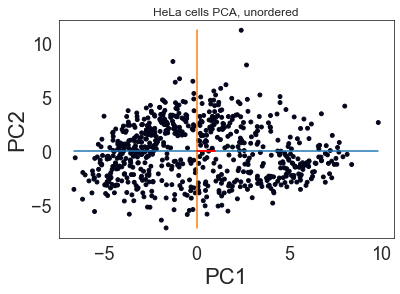

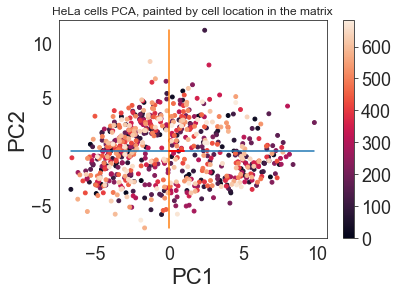

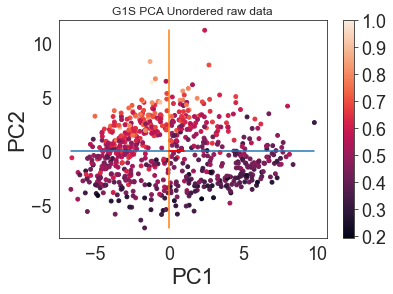

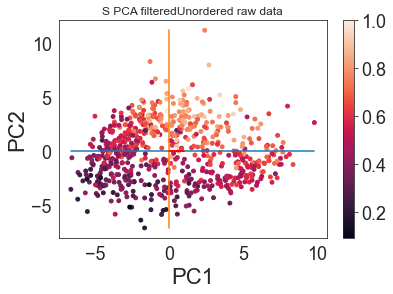

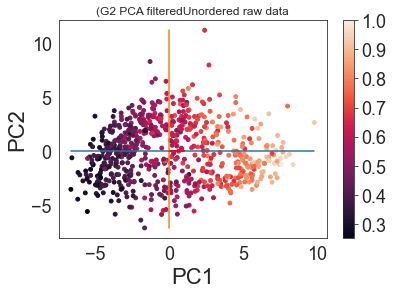

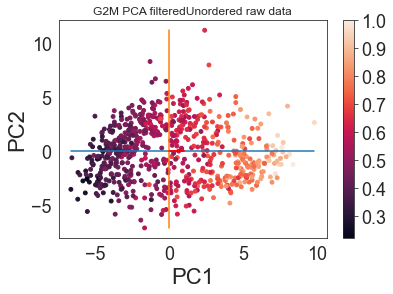

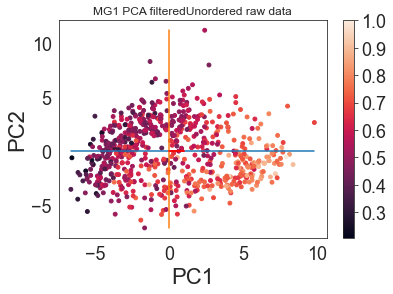

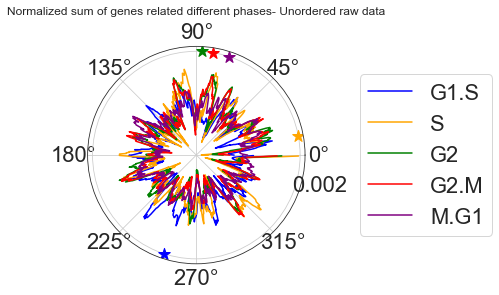

Circular mean and variance, G1S(-1.8891964171009161, 0.9879968552495557)
Circular mean and variance, S(0.18136988052985506, 0.9914548820861316)
Circular mean and variance, G2(1.5197883143837119, 0.9827674689108683)
Circular mean and variance, G2M(1.4071390989572186, 0.9791771449290153)
Circular mean and variance, MG1(1.2469984224218933, 0.9823393501796381)
Mean circular variance= 0.9847471402710418


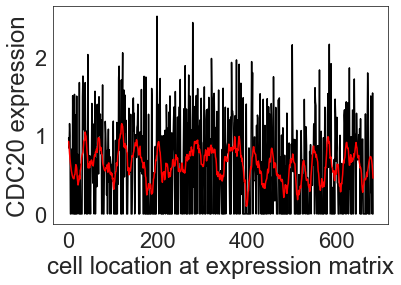

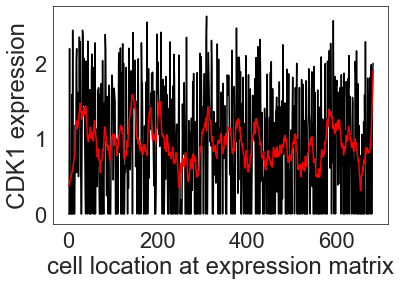

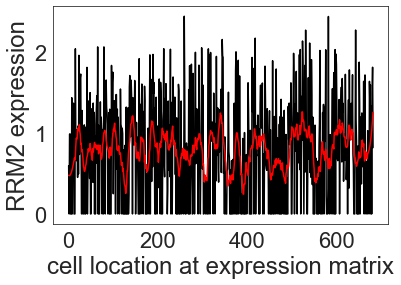

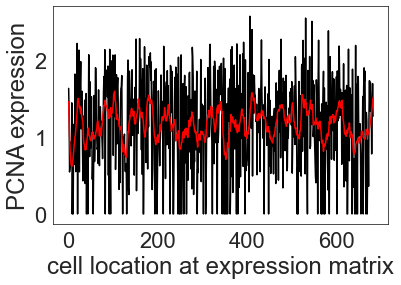

Mean AUC-ROC: 0.4149355


In [3]:
#######data cleaning#######
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
bdata = copy.deepcopy(adata.copy())
sc.pp.filter_genes_dispersion(adata,n_top_genes=7000)
ranged_pca_2d(adata.X,color=np.zeros(adata.X.shape[0]),title=("HeLa cells PCA, unordered"),dis_colorbar=True)
all_plots_hela(adata,title="Unordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='r', title="Unordered raw data")
#######Gene inference over un-ordered data- the result expected to be low#######
auc_unordered= np.zeros(100)
for i in range(100):
    auc_unordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_unordered)))

Iteration number: 0 function value= 1.1949832496162673e-22
Iteration number: 25 function value= 535.5245845203017
Iteration number: 50 function value= 564.6385718369866
Iteration number: 75 function value= 575.7383482962779
Iteration number: 100 function value= 579.077035769057
Iteration number: 125 function value= 580.6761935776374
Iteration number: 150 function value= 585.7191873975947
Iteration number: 175 function value= 584.851672815732
Iteration number: 200 function value= 587.0311743597373
Iteration number: 225 function value= 587.686062592383


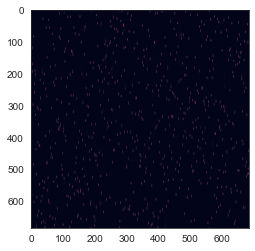

In [4]:
E_sga  , E_rec_sga = reconstruction_cyclic(adata.X , iterNum=250 , batch_size=6000)
plt.imshow(E_sga)
plt.show()

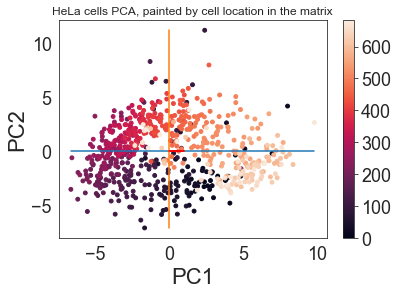

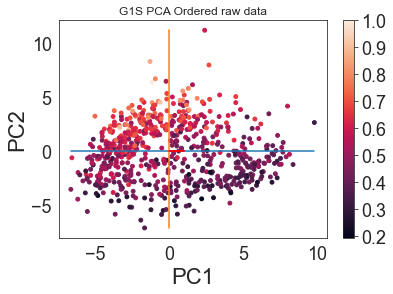

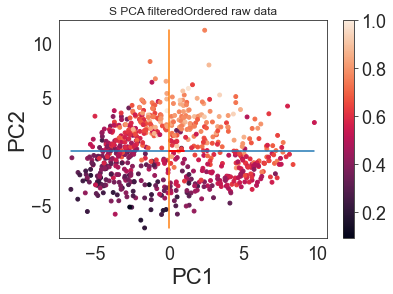

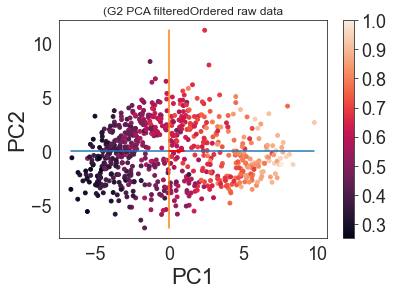

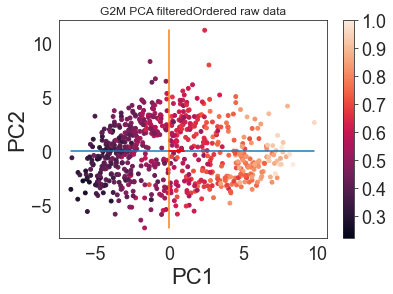

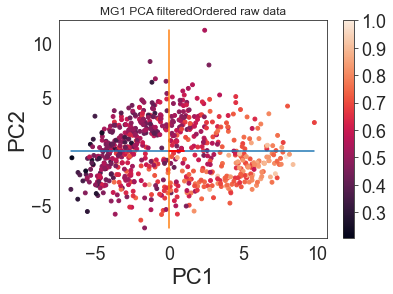

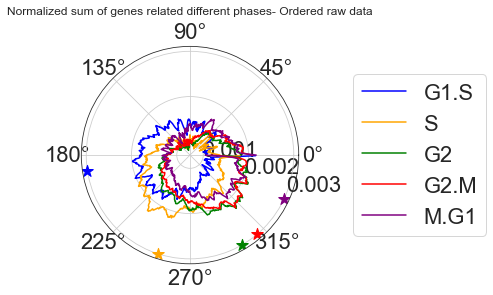

Circular mean and variance, G1S(-2.9854653008741763, 0.8922158451797485)
Circular mean and variance, S(-1.8832171380838207, 0.8264030868184182)
Circular mean and variance, G2(-1.0456541884926356, 0.8099433147429806)
Circular mean and variance, G2M(-0.8659469166512915, 0.8276996020810696)
Circular mean and variance, MG1(-0.4329098442697702, 0.892750327593835)
Mean circular variance= 0.8498024352832104


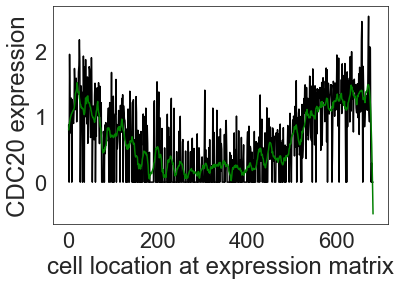

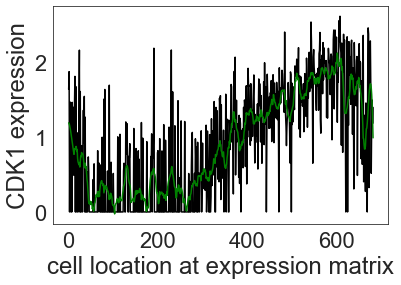

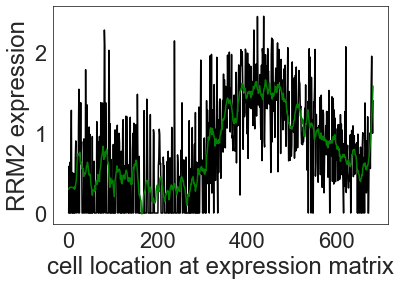

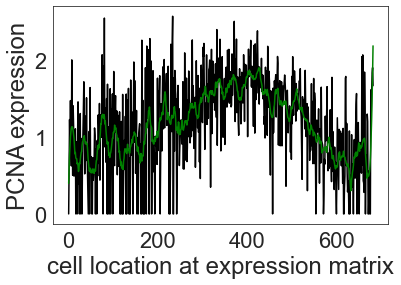

Mean AUC-ROC: 0.7915519999999999


In [5]:
#######Signal reconstruction######
sga_range= e_to_range(E_rec_sga)
adata = adata[sga_range,:]
orig_adata = copy.deepcopy(adata.copy())
all_plots_hela(adata,title="Ordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='g', title="Ordered raw data")
auc_ordered= np.zeros(100)
#######Gene inference over ordered data#######
for i in range(100):
    auc_ordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_ordered)))

Iteration number: 1 function value: 505.7454348769903
Iteration number: 26 function value: 1103.5924464616385
Iteration number: 51 function value: 2579.7517822073505
Iteration number: 76 function value: 3371.0711394125397
norm change 447.79534789032954


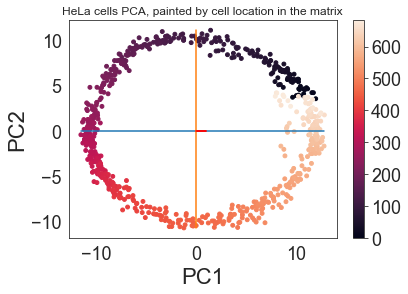

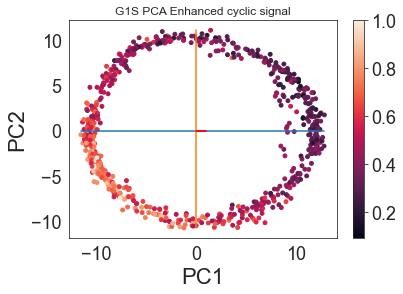

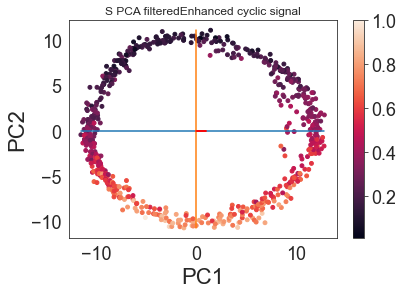

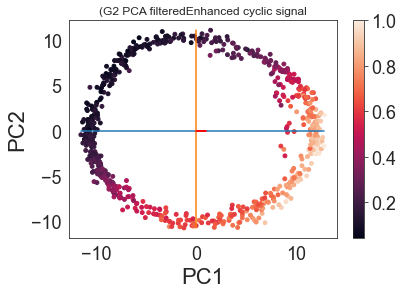

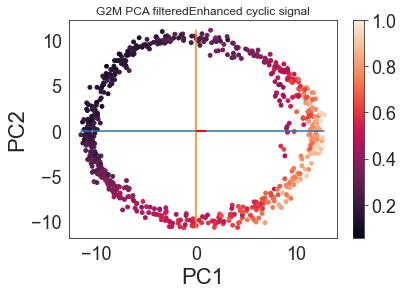

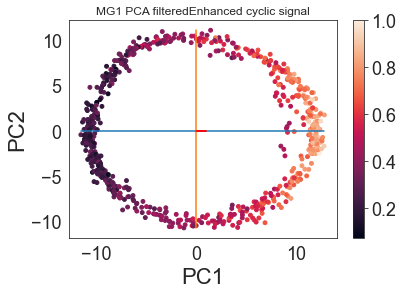

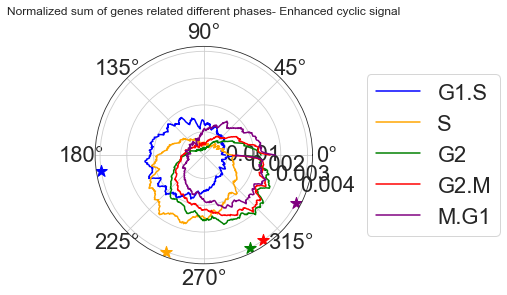

Circular mean and variance, G1S(-2.9907214730902156, 0.788656035394764)
Circular mean and variance, S(-1.9391406843796977, 0.6429442083586605)
Circular mean and variance, G2(-1.1053343272234613, 0.5610482103477188)
Circular mean and variance, G2M(-0.9629876546553062, 0.6410828169972382)
Circular mean and variance, MG1(-0.48525052638758065, 0.7005566062985753)
Mean circular variance= 0.6668575754793913


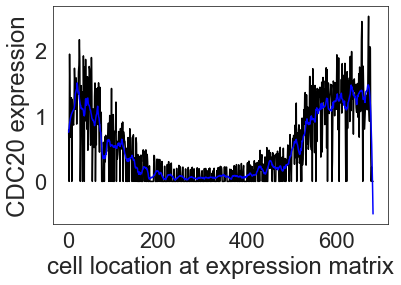

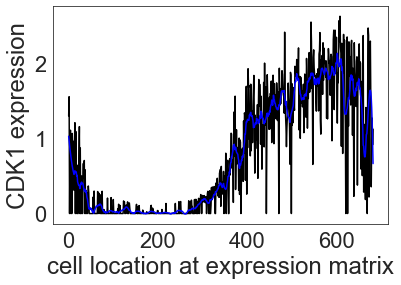

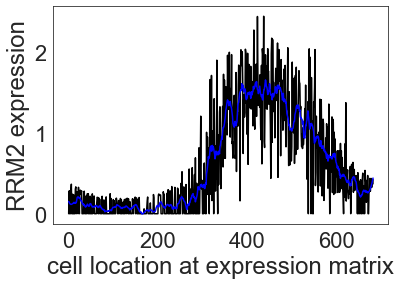

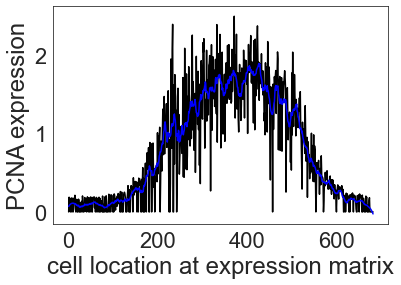

Mean AUC-ROC: 0.8239425000000001


In [6]:
#######Signal enhancement######
adata = orig_adata.copy()
F = enhancement_cyclic(adata.X,regu=0.05,iterNum=100)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Enhanced cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='b', title="Enhanced cyclic signal")
auc_en= np.zeros(100)
for i in range(100):
    auc_en[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_en)))

starting filtering
25th Iteration    Loss :: 104.2214435751402 gradient :: 2.4667690048869155
50th Iteration    Loss :: 50.24677188546022 gradient :: 1.252607789132402
75th Iteration    Loss :: 33.366489909887235 gradient :: 0.8331389368912258
100th Iteration    Loss :: 25.362018156799788 gradient :: 0.6212808768350783
125th Iteration    Loss :: 20.735970734893407 gradient :: 0.4944602576045199
150th Iteration    Loss :: 17.73203673452764 gradient :: 0.41082729746444885
175th Iteration    Loss :: 15.619966472571935 gradient :: 0.3519118994646373
200th Iteration    Loss :: 14.046914877934743 gradient :: 0.3082948319690546
225th Iteration    Loss :: 12.825378682765862 gradient :: 0.27478937666616376
250th Iteration    Loss :: 11.84538797872312 gradient :: 0.2482941755612129
275th Iteration    Loss :: 11.038744300823778 gradient :: 0.22683863903385199
300th Iteration    Loss :: 10.36086678833454 gradient :: 0.20911293519157848
325th Iteration    Loss :: 9.781118853798809 gradient :: 0.194

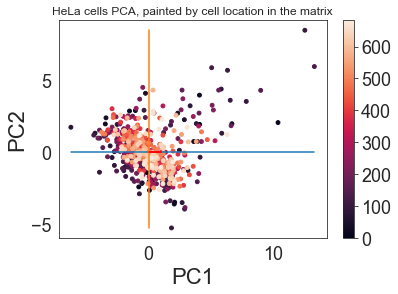

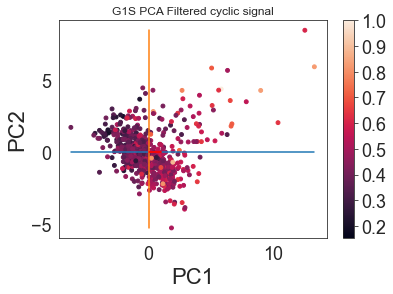

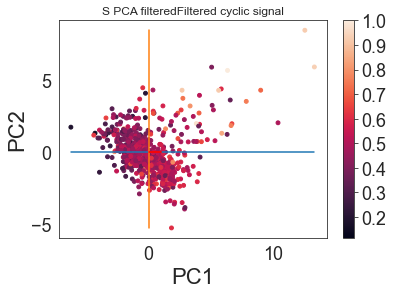

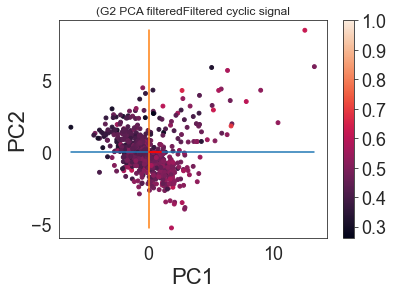

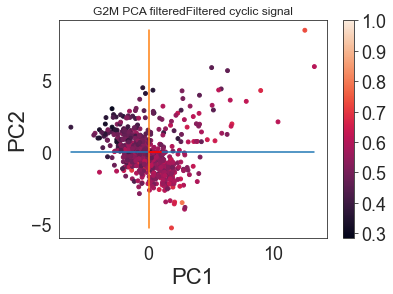

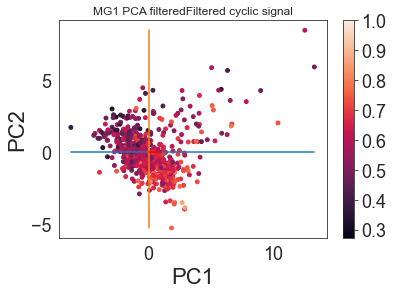

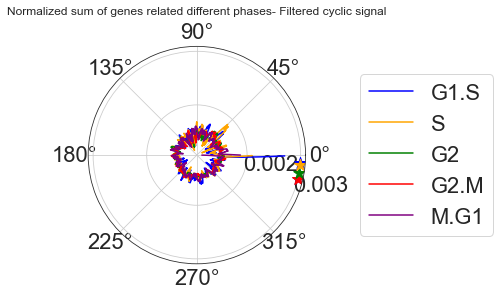

Circular mean and variance, G1S(-0.07538770019196549, 0.989401624097585)
Circular mean and variance, S(-0.09991341565345052, 0.9889148691579122)
Circular mean and variance, G2(-0.1775958300536365, 0.9887742947094412)
Circular mean and variance, G2M(-0.228051460724715, 0.9884662664660189)
Circular mean and variance, MG1(-0.2289437357817667, 0.9885611768419716)
Mean circular variance= 0.9888236462545859


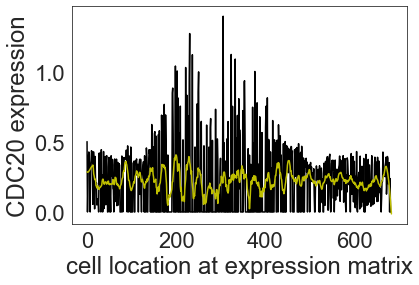

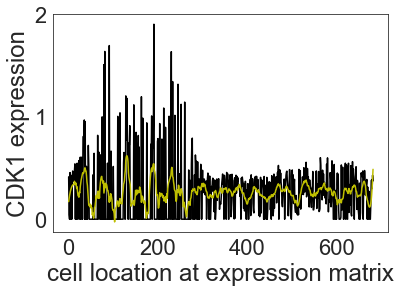

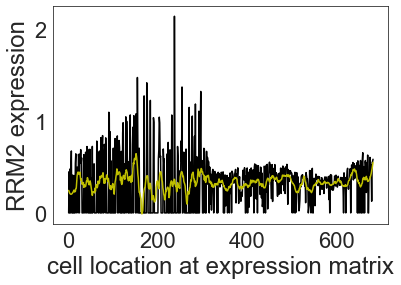

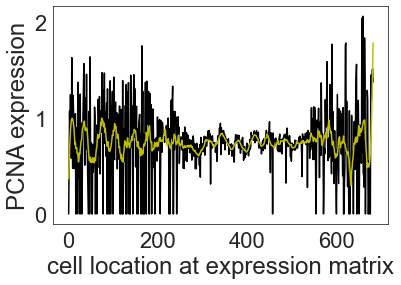

Mean AUC-ROC: 0.1856785


In [7]:
#######Signal filtering######
adata = copy.deepcopy(orig_adata.copy())
F = filtering_cyclic(adata.X,regu=0,iterNum=1500)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Filtered cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='y', title="Filtered cyclic signal")
auc_filtered= np.zeros(100)
for i in range(100):
    auc_filtered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_filtered)))

starting norm: 885.0458
Iteration number: 1 function value: 505.74748755775687
norm change 48.374112835520855


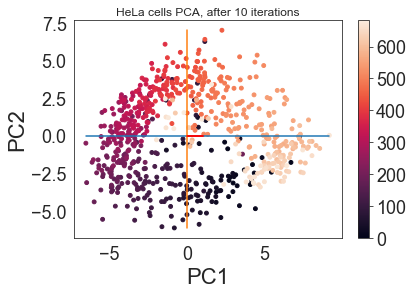

Iteration number: 1 function value: 505.7585726480066
norm change 109.38301444745919


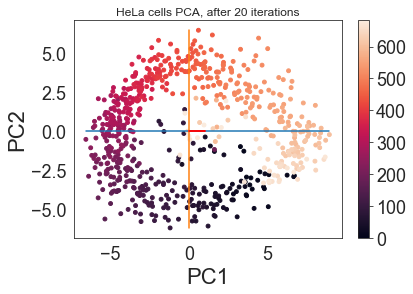

Iteration number: 1 function value: 505.7572880301329
Iteration number: 26 function value: 1103.73806591934
norm change 192.50703171179822


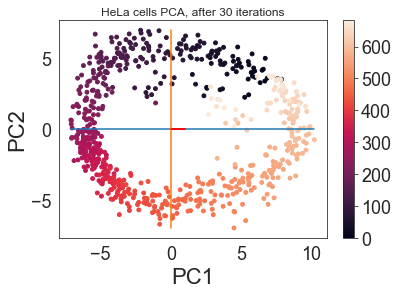

Iteration number: 1 function value: 505.7377110084991
Iteration number: 26 function value: 1103.569995277709
norm change 261.4726395497899


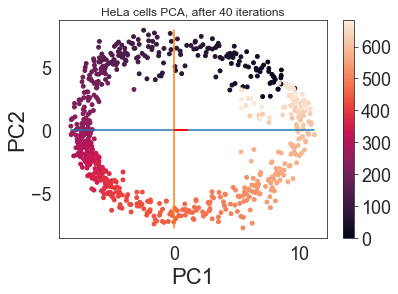

Iteration number: 1 function value: 505.755210535891
Iteration number: 26 function value: 1102.9672984986732
norm change 311.5102070376614


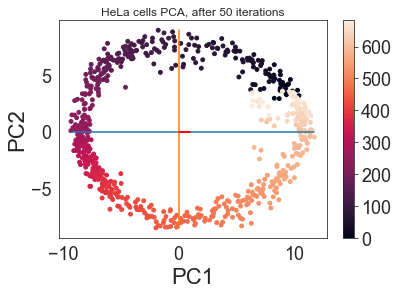

Iteration number: 1 function value: 505.7546887622581
Iteration number: 26 function value: 1104.603689821601
Iteration number: 51 function value: 2579.7768389595794
norm change 347.2496991079316


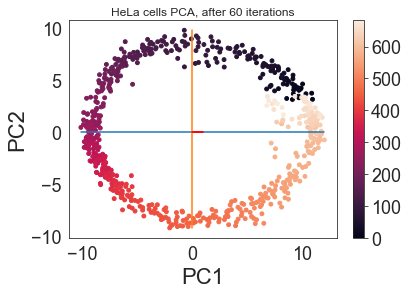

Iteration number: 1 function value: 505.7435366165697
Iteration number: 26 function value: 1103.158416145134
Iteration number: 51 function value: 2579.3682100011815
norm change 377.12776878662174


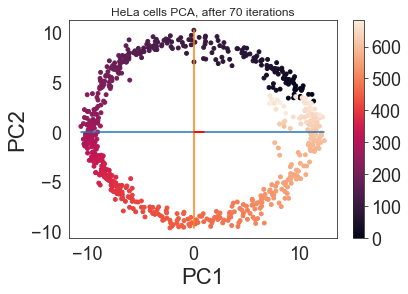

Iteration number: 1 function value: 505.7677374648608
Iteration number: 26 function value: 1103.3295324229475
Iteration number: 51 function value: 2579.656758334646
Iteration number: 76 function value: 3370.7317325208815
norm change 403.93283372186335


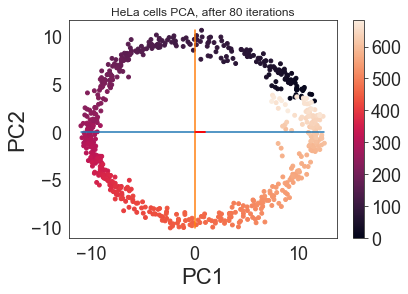

Iteration number: 1 function value: 505.7568115346385
Iteration number: 26 function value: 1103.664648687192
Iteration number: 51 function value: 2579.778046887028
Iteration number: 76 function value: 3370.597310043743
norm change 427.3633420962907


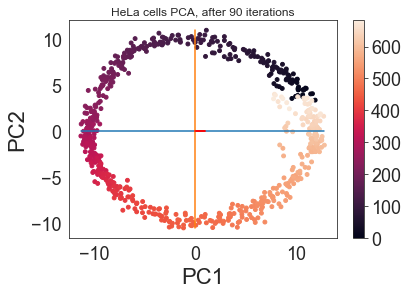

Iteration number: 1 function value: 505.7406906742375
Iteration number: 26 function value: 1103.0834433781986
Iteration number: 51 function value: 2579.915493095448
Iteration number: 76 function value: 3370.6860929605245
norm change 447.7423798667665


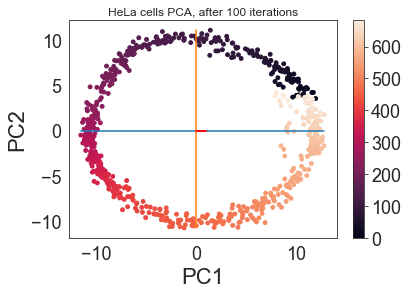

In [8]:
print("starting norm: " +str(np.linalg.norm(orig_adata.X)))
adata = copy.deepcopy(orig_adata.copy())
for i in range(10):
    adata = copy.deepcopy(orig_adata.copy())
    F = enhancement_cyclic(adata.X,regu=0.05,iterNum=(10*(i+1)))
    print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
    adata.X = adata.X * F
    ranged_pca_2d(adata.X,color=range(adata.X.shape[0]),title=("HeLa cells PCA, after "+ str((i+1)*10) +" iterations"))

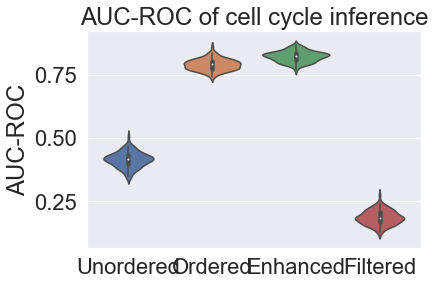

In [9]:
data = pd.DataFrame({
    "Unordered": auc_unordered,
    'Ordered': auc_ordered,
    "Enhanced": auc_en,
    "Filtered": auc_filtered,
})
sns.set_style("whitegrid")

sns.set_style("white", {"axes.facecolor": ".9"})
sns.set_style("whitegrid")

sns.set(font_scale=2)
ax = sns.violinplot(data=data)
plt.ylabel("AUC-ROC")
plt.title("AUC-ROC of cell cycle inference" ,fontsize='24')
plt.show()

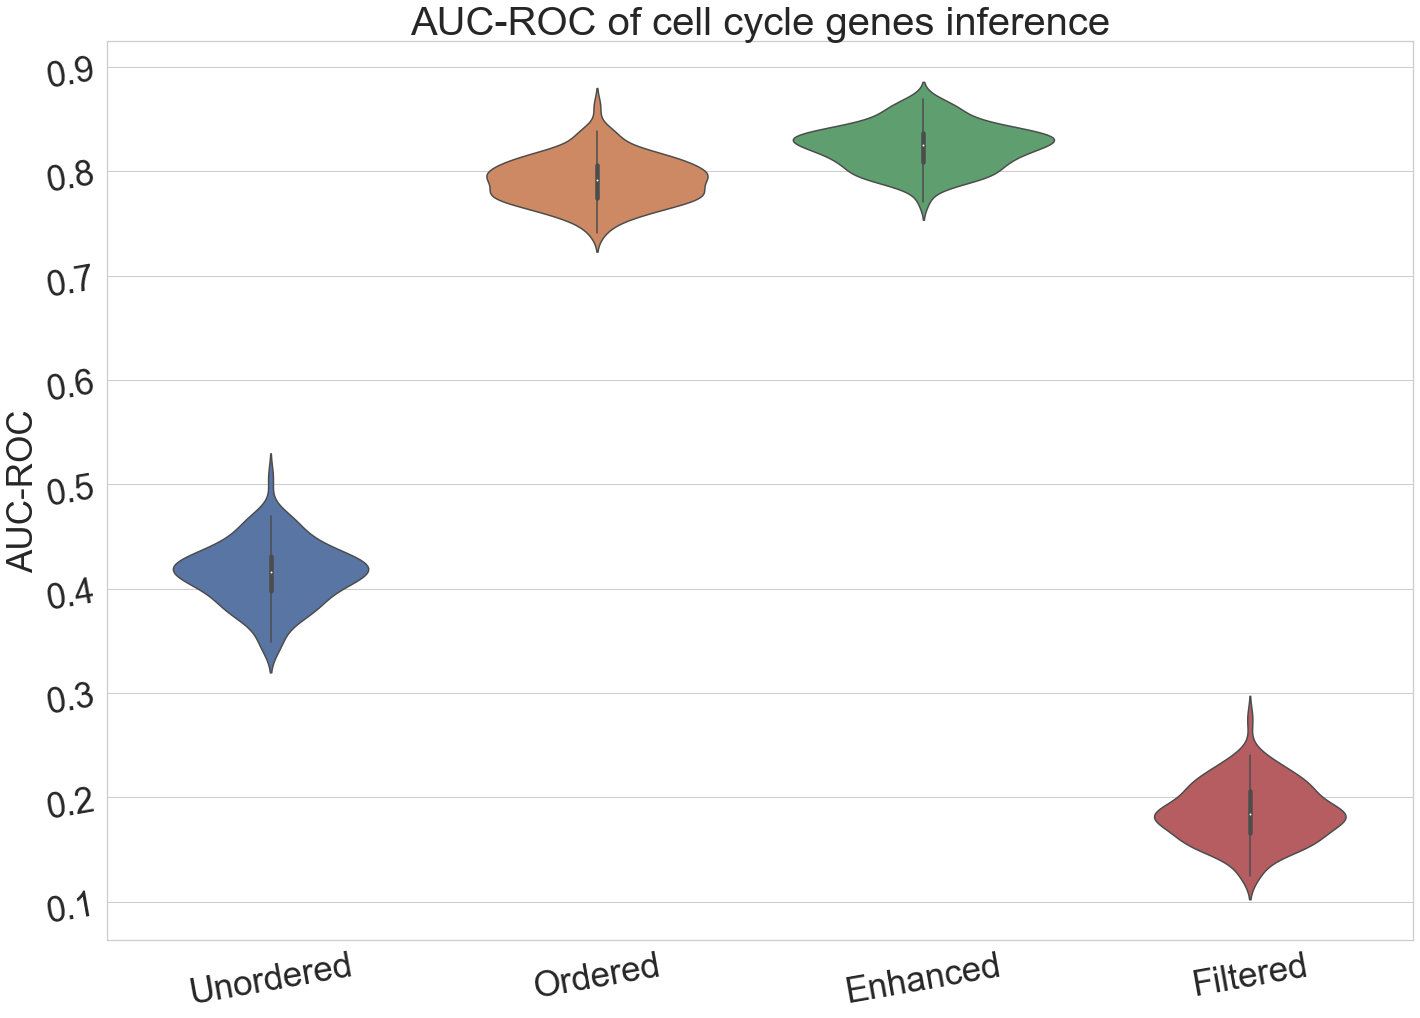

In [11]:
sns.set_style("whitegrid")

b = sns.violinplot(data=data)
#b.axes.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={'figure.figsize':(23.4,16.54)})
b.axes.set_title("AUC-ROC of cell cycle genes inference",fontsize=40)
b.set_ylabel("AUC-ROC",fontsize=35)
b.tick_params(rotation=10,labelsize=35)
#b.axes.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


sns.set(rc={'figure.figsize':(23.4,16.54)})
#plt.title("MSE between simulated cyclic signal and output of enhancement methods" ,fontsize='24')

sns.set_style("whitegrid")

plt.show()